# TESTING

In [1]:
from utils import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt

N = 5

data = prepare_mnist_data()
trainX = data['trainX']
trainY = data['trainY']

unique, counts = np.unique(trainY, return_counts=True)
for u,c in zip(unique,counts):
    print(f"class {u}: instances {c}")

def Covariance(X,y):
    N_features = X.shape[1]
    cov_vec = np.zeros(N_features)
    for i in range(X.shape[1]):
        x_i = X[:,i]
        xbar, ybar = x_i.mean(), y.mean()
        cov_vec[i] = np.sum((x_i-xbar)*(y-ybar))/(len(x_i)-1)
    return cov_vec

class 0.0: instances 327
class 3.0: instances 356
class 4.0: instances 317


**CLUSTERING**

(784,)
0.30447099999998545
0.30447100000000005
9497.502784000053


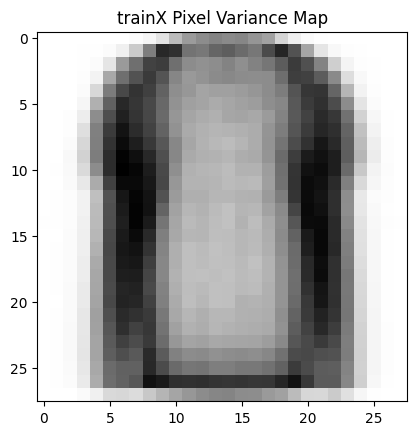

In [19]:
foo = np.var(trainX, axis=0)
print(foo.shape)
print(foo[0])
print(np.var(trainX[:,0]))
print(max(foo))

plt.imshow(np.reshape(foo, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.title("trainX Pixel Variance Map")
plt.show()

**CLASSIFICATION**

In [2]:
# Get dataset unique labels and the sample indices corresponding to those labels
from scipy.spatial.distance import cdist
from gekko import GEKKO

unique_labels = np.unique(trainY)
indices_per_label = []
for i, label in enumerate(unique_labels):
    indices = np.where(trainY == label)
    indices_per_label.append(indices)

# Assume no access to itertools, just use the known possible pairs given the fashion mnist dataset
label_pairs = ((0,1), (0,2), (1,2))

pairwise_covariances = []

# Iterate across all potential label pairs
for (lbl_idx_a, lbl_idx_b) in label_pairs:
    lbl_a = unique_labels[lbl_idx_a]
    lbl_b = unique_labels[lbl_idx_b]

    # Combine sample indices from both classes
    indices = np.append(indices_per_label[lbl_idx_a], indices_per_label[lbl_idx_b])

    # Get X and Y samples from the indices
    X_prime = np.take(trainX, indices, axis=0)
    Y_prime = np.take(trainY, indices)
    
    # X_prime = trainX.copy()
    # Y_prime = trainY.copy()

    # print(X_prime.shape)
    # print(Y_prime.shape)

    # relabel original class labels to -1, +1
    for i in range(len(Y_prime)):
        if Y_prime[i] == lbl_a:
            Y_prime[i] = 1
        elif Y_prime[i] == lbl_b:
        # else:
            Y_prime[i] = -1
    
    # compute covariance for the pair of labels
    pair_covariance = Covariance(X_prime, Y_prime)
    pairwise_covariances.append(np.absolute(pair_covariance))

    # constraints = LinearConstraint
    # selection = cvxpy.Variable(trainX.shape[1])

    # variable = cvxpy.

feature_counts = [5, 20, 80, 320, 784]
# feature_counts = [20]

selected_features = {}

for feature_count in feature_counts:
    mdl = GEKKO(remote=False)

    # Define max features
    K = mdl.Const(feature_count)

    # Define covariance vector constants
    z_0_1 = [mdl.Const(value=val) for val in pairwise_covariances[0]]
    z_0_2 = [mdl.Const(value=val) for val in pairwise_covariances[1]]
    z_1_2 = [mdl.Const(value=val) for val in pairwise_covariances[2]]

    # Define t_min auxiliary variable
    t_min = mdl.Var(value=0, lb=0)

    # Define pixel selection vector, with its integrality and 0/1 constraints
    # s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]
    s = [mdl.Var(value=0, lb=0, ub=1) for i in range(trainX.shape[1])]


    # Add regularization variables to incentivize distance bewteen seleted points
    # Want to try to minimize variance across each dimension - spread selected pixels equally across columns and rows
    
    image_side_length = int(trainX.shape[1]**.5)
    # Column sum
    col_sums = [mdl.Intermediate(mdl.sum([s[i+image_side_length*j] for j in range(image_side_length)])) for i in range(image_side_length)]
    # Row sum
    row_sums = [mdl.Intermediate(mdl.sum([s[image_side_length*i+j] for j in range(image_side_length)])) for i in range(image_side_length)]

    # Row and column averages
    col_avg = mdl.Intermediate(sum(col_sums) / image_side_length)
    row_avg = mdl.Intermediate(sum(row_sums) / image_side_length)

    # Absolute col/row sum deviations from average
    col_abs_deviation = [mdl.abs2(csum-col_avg) for csum in col_sums]
    row_abs_deviation = [mdl.abs2(rsum-row_avg) for rsum in row_sums]

    # Compute variances for rows and columns
    col_var = mdl.Intermediate(mdl.sum([dev for dev in col_abs_deviation]) / (image_side_length))
    row_var = mdl.Intermediate(mdl.sum([dev for dev in row_abs_deviation]) / (image_side_length))

    lambda1 = 1E2
    lambda2 = 1E2


    # print(len(s))
    # Define constraints
    ## Max number of pixels constraint
    mdl.Equation(np.sum(s) <= K)

    ## Set t_min to the min sum absolute covariance across all class pairs
    # mdl.Equation(t_min <= np.dot(s, z_0_1))
    # mdl.Equation(t_min <= np.dot(s, z_0_2))
    # mdl.Equation(t_min <= np.dot(s, z_1_2))
    ### Reformulate dot products as element-wise multiply and sum to avoid errors in GEKKO
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_1_i for (s_i, z_0_1_i) in zip(s,z_0_1)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_0_2_i for (s_i, z_0_2_i) in zip(s,z_0_2)]))
    mdl.Equation(t_min <= mdl.sum([s_i*z_1_2_i for (s_i, z_1_2_i) in zip(s,z_1_2)]))

    
    # Set objective function to maximize t_min - regularization terms
    mdl.Maximize(t_min + lambda1*col_var - lambda2*row_var)

    # mdl.Obj(t_min + ())

    # mdl.options.MAX_ITER = 400
    mdl.options.SOLVER = 1    
    mdl.options.IMODE = 3

    mdl.solver_options = [  'minlp_gap_tol 1.0e-1',\
                            'minlp_maximum_iterations 1000',\
                            'minlp_max_iter_with_int_sol 400']

    mdl.solve(disp=True)

    print(f"t value: {t_min.value}")
    # print(f"col_avg value: {col_avg.value}")
    # print(f"row_avg value: {row_avg.value}")
    # print(f"col_abs_deviation value: {[cad.value for cad in col_abs_deviation]}")
    # print(f"row_abs_deviation value: {[rad.value for rad in row_abs_deviation]}")
    print(f"col_var value: {col_var.value}")
    print(f"row_var value: {row_var.value}")
    # print(f"reg1 value: {reg1.value}")
    # print(f"reg2 value: {reg2.value}")

    selected_features[feature_count] = np.array([s_i.value for s_i in s])

 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  117
   Constants    :  2353
   Variables    :  3314
   Intermediates:  60
   Connections  :  4149
   Equations    :  2473
   Residuals    :  2413
 
 Number of state variables:    3426
 Number of total equations: -  2585
 Number of slack variables: -  4
 ---------------------------------------
 Degrees of freedom       :    837
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -3.86743E-01  5.00000E+00
    1 -1.03931E+02  2.23492E-07
    2 -1.84654E+02  2.00000E-10
    3 -1.92434E+02  3.00001E-10
    4 -1.93784E+02  3.00000E-10
    5 -1.93786E+02  1.99999E-10
    6 -1.93801E+02  5.00000

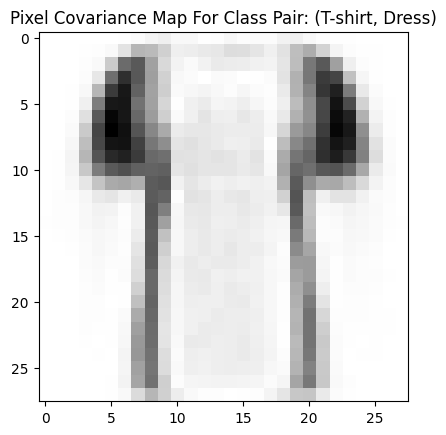

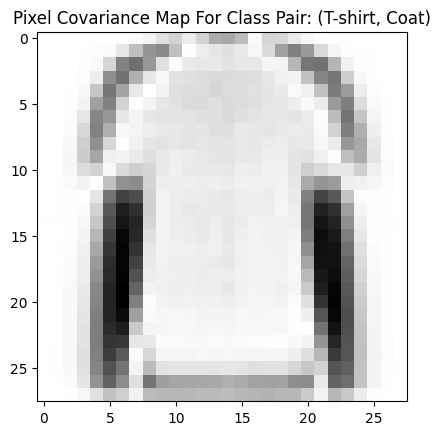

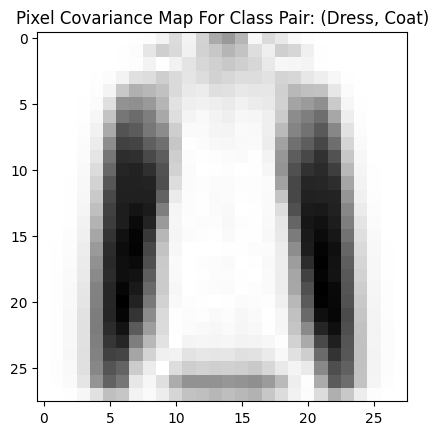

In [18]:
unique_labels
# 0 T-shirt/top
# 3 Dress
# 4 Coat

plt.imshow(np.reshape(pairwise_covariances[0], (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.title(f"Pixel Covariance Map For Class Pair: (T-shirt, Dress)")
plt.show()

plt.imshow(np.reshape(pairwise_covariances[1], (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.title(f"Pixel Covariance Map For Class Pair: (T-shirt, Coat)")
plt.show()

plt.imshow(np.reshape(pairwise_covariances[2], (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
plt.title(f"Pixel Covariance Map For Class Pair: (Dress, Coat)")
plt.show()


In [16]:
# pairwise_covariances[0].shape

(784,)

Original num of nonzero features: 40


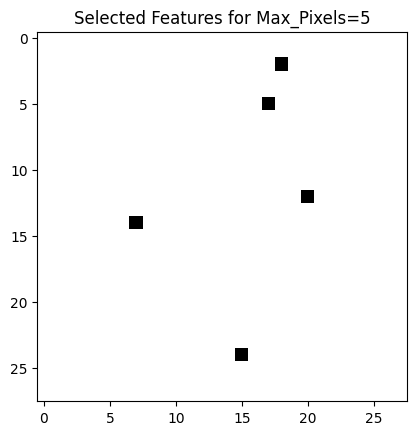

[ 74,157,356,399,687]
Selected Features: 5
Original num of nonzero features: 42


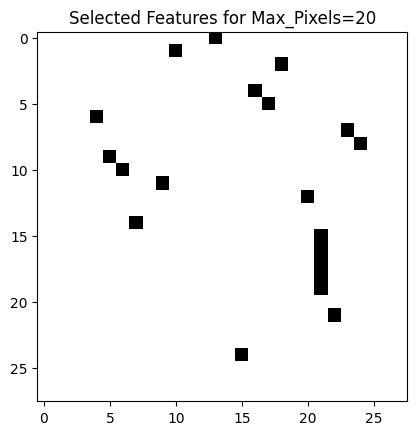

[ 13, 38, 74,128,157,172,219,248,257,286,317,356,399,441,469,497,525,553,
 610,687]
Selected Features: 20
Original num of nonzero features: 92


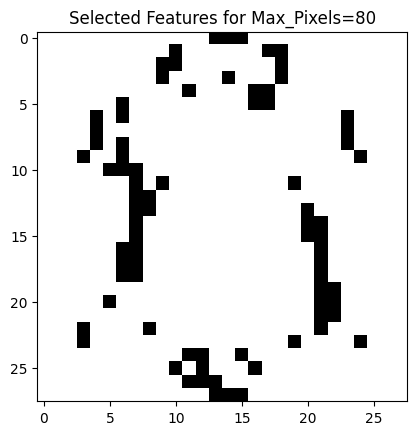

[ 13, 14, 15, 38, 45, 46, 65, 66, 74, 93, 98,102,123,128,129,146,156,157,
 172,174,191,200,219,228,230,247,255,258,276,285,286,287,315,317,327,343,
 344,371,372,384,399,412,413,427,440,441,454,455,469,482,483,497,510,511,
 525,553,554,565,581,582,609,610,619,624,637,647,663,668,683,684,687,710,
 712,716,739,740,741,769,770,771]
Selected Features: 80
Original num of nonzero features: 340


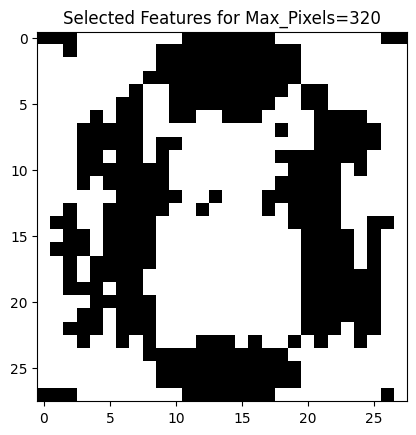

[  0,  1,  2, 11, 12, 13, 14, 15, 16, 17, 26, 27, 30, 37, 38, 39, 40, 41,
  42, 43, 44, 45, 46, 47, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 92,
  93, 94, 95, 96, 97, 98, 99,100,101,102,103,119,122,123,124,125,126,127,
 128,129,130,132,133,146,147,150,151,152,153,154,155,156,157,160,161,172,
 174,175,178,179,182,183,184,189,190,191,192,199,200,201,202,203,214,217,
 218,219,220,221,227,228,229,230,231,233,234,245,246,247,248,249,255,256,
 258,259,261,270,271,272,273,274,275,276,283,284,285,286,287,288,289,299,
 300,301,302,304,311,313,314,315,316,317,326,327,328,329,330,342,343,344,
 345,346,349,353,354,355,356,357,358,366,369,370,371,372,373,376,381,383,
 384,385,386,393,394,397,398,399,400,411,412,413,414,417,418,422,423,425,
 426,427,428,440,441,442,443,445,449,450,451,453,454,455,456,468,469,470,
 471,473,478,480,481,482,483,484,496,497,498,499,501,506,508,509,510,511,
 524,525,526,527,528,529,534,535,536,538,539,552,553,554,555,556,557,564,
 565,566,567,568,580,581,582,583,584,5

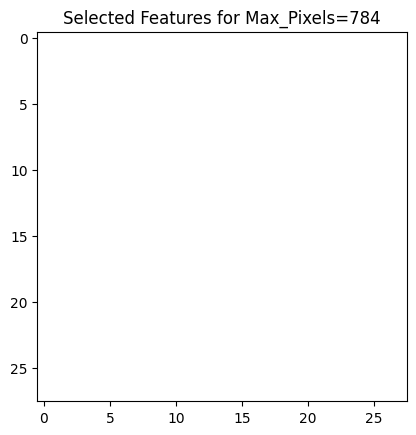

[  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
  36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
  54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
  72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,100,101,102,103,104,105,106,107,
 108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,
 126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,
 144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,
 162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,
 180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,
 198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,
 216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,
 234,235,236,237,238,239,240,241,242,2

In [7]:
for feature_count in feature_counts:
    features = selected_features[feature_count].flatten()

    print(f"Original num of nonzero features: {len(np.nonzero(features)[0])}")

    # Take the max features and display
    ind = np.argpartition(features, -1*feature_count)[-1*feature_count:]
    features = np.zeros(784)
    features[ind]=1


    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()

    feature_indices = np.nonzero(features)[0]
    print(np.array2string(feature_indices, separator = ','))
    print(f"Selected Features: {len(feature_indices)}")
    

**CLASSIFICATION FEATURES BACKUP**

In [51]:
classification_features_K5 = np.array([ 74,157,356,399,687])

classification_features_K20 = np.array([ 13, 38, 74,128,157,172,219,248,257,286,317,356,399,441,469,497,525,553,
610,687])

classification_features_K80 = np.array([ 13, 14, 15, 38, 45, 46, 65, 66, 74, 93, 98,102,123,128,129,146,156,157,
 172,174,191,200,219,228,230,247,255,258,276,285,286,287,315,317,327,343,
 344,371,372,384,399,412,413,427,440,441,454,455,469,482,483,497,510,511,
 525,553,554,565,581,582,609,610,619,624,637,647,663,668,683,684,687,710,
 712,716,739,740,741,769,770,771])

classification_features_K320 = np.array([  0,  1,  2, 11, 12, 13, 14, 15, 16, 17, 26, 27, 30, 37, 38, 39, 40, 41,
  42, 43, 44, 45, 46, 47, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 92,
  93, 94, 95, 96, 97, 98, 99,100,101,102,103,119,122,123,124,125,126,127,
 128,129,130,132,133,146,147,150,151,152,153,154,155,156,157,160,161,172,
 174,175,178,179,182,183,184,189,190,191,192,199,200,201,202,203,214,217,
 218,219,220,221,227,228,229,230,231,233,234,245,246,247,248,249,255,256,
 258,259,261,270,271,272,273,274,275,276,283,284,285,286,287,288,289,299,
 300,301,302,304,311,313,314,315,316,317,326,327,328,329,330,342,343,344,
 345,346,349,353,354,355,356,357,358,366,369,370,371,372,373,376,381,383,
 384,385,386,393,394,397,398,399,400,411,412,413,414,417,418,422,423,425,
 426,427,428,440,441,442,443,445,449,450,451,453,454,455,456,468,469,470,
 471,473,478,480,481,482,483,484,496,497,498,499,501,506,508,509,510,511,
 524,525,526,527,528,529,534,535,536,538,539,552,553,554,555,556,557,564,
 565,566,567,568,580,581,582,583,584,585,591,592,594,595,596,608,609,610,
 611,612,613,618,619,620,622,623,624,636,637,638,640,641,647,650,652,656,
 657,658,660,663,665,668,680,681,682,683,684,685,686,687,688,689,690,709,
 710,711,712,713,714,715,716,717,718,719,737,738,739,740,741,742,743,744,
 745,746,747,756,757,758,767,768,769,770,771,772,773,782])

classification_features_K784 = np.array(range(0,784))

selected_features = {}
selected_features[5] = np.zeros(784)
selected_features[20] = np.zeros(784)
selected_features[80] = np.zeros(784)
selected_features[320] = np.zeros(784)
selected_features[784] = np.zeros(784)

selected_features[5][classification_features_K5] = 1
selected_features[20][classification_features_K20] = 1
selected_features[80][classification_features_K80] = 1
selected_features[320][classification_features_K320] = 1
selected_features[784][classification_features_K784] = 1

**CLUSTERING**

In [10]:
# Get dataset unique labels and the sample indices corresponding to those labels
from scipy.spatial.distance import cdist
from gekko import GEKKO

feature_counts = [5, 20, 80, 320, 784]
# feature_counts = [20]
selected_features = {}

for feature_count in feature_counts:
        print(f"running feature count: {feature_count}")
        # Compute pixel variances
        variance = np.var(trainX, axis=0)

        ## Formulate and run the Integer Linear Program
        mdl = GEKKO(remote=False)

        # Define max number of features
        K = mdl.Const(feature_count)

        # Define covariance vector constants
        z = [mdl.Const(value=val) for val in variance]

        # Define t_min auxiliary variable
        t = mdl.Var(value=0, lb=0)

        # Define pixel selection vector, with its integrality and 0/1 constraints
        # s = [mdl.Var(value=0, lb=0, ub=1, integer=True) for i in range(trainX.shape[1])]
        s = [mdl.Var(value=0, lb=0, ub=1) for i in range(trainX.shape[1])]


        # Add regularization variables to incentivize distance bewteen seleted points
        # Want to try to minimize variance across each dimension - spread selected pixels equally across columns and rows
        
        image_side_length = int(trainX.shape[1]**.5)
        # Column sum
        col_sums = [mdl.Intermediate(mdl.sum([s[i+image_side_length*j] for j in range(image_side_length)])) for i in range(image_side_length)]
        # Row sum
        row_sums = [mdl.Intermediate(mdl.sum([s[image_side_length*i+j] for j in range(image_side_length)])) for i in range(image_side_length)]

        # Row and column averages
        col_avg = mdl.Intermediate(sum(col_sums) / image_side_length)
        row_avg = mdl.Intermediate(sum(row_sums) / image_side_length)

        # Absolute col/row sum deviations from average
        col_abs_deviation = [mdl.abs2(csum-col_avg) for csum in col_sums]
        row_abs_deviation = [mdl.abs2(rsum-row_avg) for rsum in row_sums]

        # Compute variances for rows and columns
        col_var = mdl.Intermediate(mdl.sum([dev for dev in col_abs_deviation]) / (image_side_length))
        row_var = mdl.Intermediate(mdl.sum([dev for dev in row_abs_deviation]) / (image_side_length))

        lambda1 = 1E5
        lambda2 = 1E5


        # Define constraints
        ## Max number of pixels constraint
        mdl.Equation(np.sum(s) <= K)
        ## Set t to the sum variance across all selected pixels
        mdl.Equation(t <= mdl.sum([s_i*z_i for (s_i, z_i) in zip(s,z)]))
        

        # Set objective function to maximize t
        mdl.Maximize(t - lambda1*col_var - lambda2*row_var)
        mdl.options.MAX_ITER = 10000
        mdl.options.SOLVER = 1    
        mdl.options.IMODE = 3
        # mdl.solve(disp=True)
        mdl.solve()

        # Get the 1/0 mask of selected features from the final values of s
        feature_mask = np.array([s_i.value for s_i in s])
        
        print(f"t value: {t.value}")
        # print(f"col_avg value: {col_avg.value}")
        # print(f"row_avg value: {row_avg.value}")
        # print(f"col_abs_deviation value: {[cad.value for cad in col_abs_deviation]}")
        # print(f"row_abs_deviation value: {[rad.value for rad in row_abs_deviation]}")
        print(f"col_var value: {col_var.value}")
        print(f"row_var value: {row_var.value}")
        # print(f"reg1 value: {reg1.value}")
        # print(f"reg2 value: {reg2.value}")

        print([cs.value for cs in col_sums])

        selected_features[feature_count] = feature_mask

        # Get feature indices of the selected features from the mask
        selected_feature_indices = np.nonzero(feature_mask)[0]



running feature count: 5


 ----------------------------------------------------------------
 APMonitor, Version 1.0.3
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :  115
   Constants    :  785
   Variables    :  1742
   Intermediates:  60
   Connections  :  2579
   Equations    :  903
   Residuals    :  843
 
 Number of state variables:    1854
 Number of total equations: -  1013
 Number of slack variables: -  2
 ---------------------------------------
 Degrees of freedom       :    839
 
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -5.08841E-01  5.00000E+00
    1 -2.82060E+04  1.83017E-06
    2 -2.82819E+04  2.21443E-05
    3 -2.82819E+04  9.49335E-09
    4 -2.82819E+04  8.88178E-16
    5 -2.82819E+04  8.88178E-16
 Successful solution
 
 ------

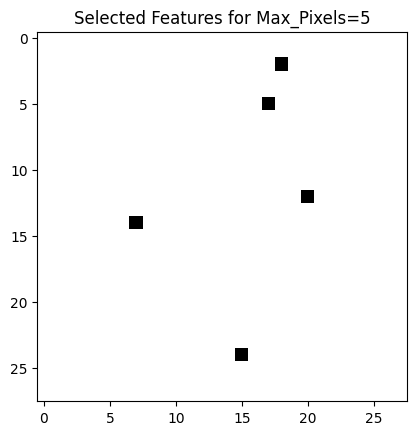

[ 74,157,356,399,687]
Selected Features: 5


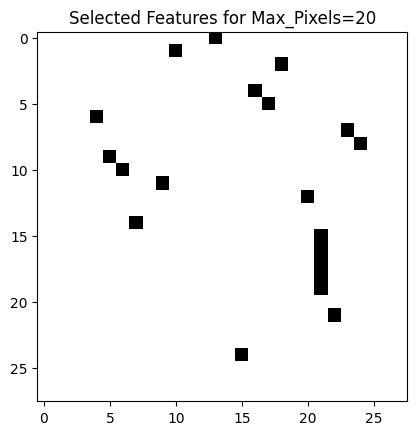

[ 13, 38, 74,128,157,172,219,248,257,286,317,356,399,441,469,497,525,553,
 610,687]
Selected Features: 20


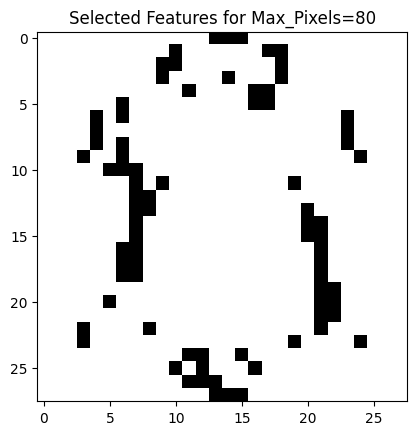

[ 13, 14, 15, 38, 45, 46, 65, 66, 74, 93, 98,102,123,128,129,146,156,157,
 172,174,191,200,219,228,230,247,255,258,276,285,286,287,315,317,327,343,
 344,371,372,384,399,412,413,427,440,441,454,455,469,482,483,497,510,511,
 525,553,554,565,581,582,609,610,619,624,637,647,663,668,683,684,687,710,
 712,716,739,740,741,769,770,771]
Selected Features: 80


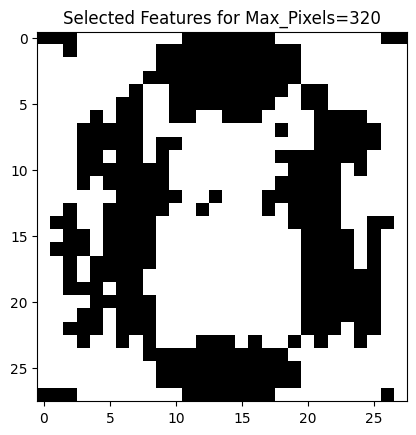

[  0,  1,  2, 11, 12, 13, 14, 15, 16, 17, 26, 27, 30, 37, 38, 39, 40, 41,
  42, 43, 44, 45, 46, 47, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 92,
  93, 94, 95, 96, 97, 98, 99,100,101,102,103,119,122,123,124,125,126,127,
 128,129,130,132,133,146,147,150,151,152,153,154,155,156,157,160,161,172,
 174,175,178,179,182,183,184,189,190,191,192,199,200,201,202,203,214,217,
 218,219,220,221,227,228,229,230,231,233,234,245,246,247,248,249,255,256,
 258,259,261,270,271,272,273,274,275,276,283,284,285,286,287,288,289,299,
 300,301,302,304,311,313,314,315,316,317,326,327,328,329,330,342,343,344,
 345,346,349,353,354,355,356,357,358,366,369,370,371,372,373,376,381,383,
 384,385,386,393,394,397,398,399,400,411,412,413,414,417,418,422,423,425,
 426,427,428,440,441,442,443,445,449,450,451,453,454,455,456,468,469,470,
 471,473,478,480,481,482,483,484,496,497,498,499,501,506,508,509,510,511,
 524,525,526,527,528,529,534,535,536,538,539,552,553,554,555,556,557,564,
 565,566,567,568,580,581,582,583,584,5

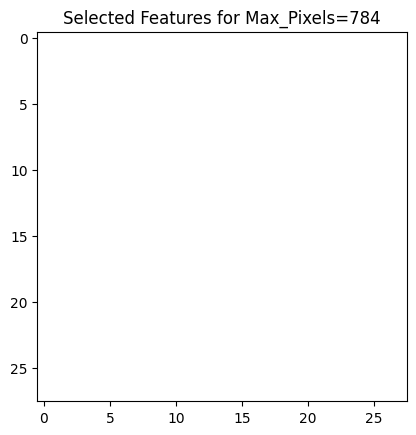

[  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
  36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
  54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
  72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
  90, 91, 92, 93, 94, 95, 96, 97, 98, 99,100,101,102,103,104,105,106,107,
 108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,
 126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,
 144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,
 162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,
 180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,
 198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,
 216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,
 234,235,236,237,238,239,240,241,242,2

In [11]:
for feature_count in feature_counts:
    features = selected_features[feature_count].flatten()

    # Take the max features and display
    ind = np.argpartition(features, -1*feature_count)[-1*feature_count:]
    features = np.zeros(784)
    features[ind]=1

    plt.imshow(np.reshape(features, (28,28)), cmap=plt.get_cmap('Greys'), interpolation='nearest')
    plt.title(f"Selected Features for Max_Pixels={feature_count}")
    plt.show()
    

    feature_indices = np.nonzero(features)[0]
    print(np.array2string(feature_indices, separator = ','))
    print(f"Selected Features: {len(feature_indices)}")

**CLUSTERING FEATURES BACKUP**

In [37]:
cluster_features_K5 = np.array([ 74,157,356,399,687])

cluster_features_K20 = np.array([ 13, 38, 74,128,157,172,219,248,257,286,317,356,399,441,469,497,525,553,
 610,687])

cluster_features_K80 = np.array([ 13, 14, 15, 38, 45, 46, 65, 66, 74, 93, 98,102,123,128,129,146,156,157,
 172,174,191,200,219,228,230,247,255,258,276,285,286,287,315,317,327,343,
 344,371,372,384,399,412,413,427,440,441,454,455,469,482,483,497,510,511,
 525,553,554,565,581,582,609,610,619,624,637,647,663,668,683,684,687,710,
 712,716,739,740,741,769,770,771])

cluster_features_K320 = np.array([  0,  1,  2, 11, 12, 13, 14, 15, 16, 17, 26, 27, 30, 37, 38, 39, 40, 41,
  42, 43, 44, 45, 46, 47, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 92,
  93, 94, 95, 96, 97, 98, 99,100,101,102,103,119,122,123,124,125,126,127,
 128,129,130,132,133,146,147,150,151,152,153,154,155,156,157,160,161,172,
 174,175,178,179,182,183,184,189,190,191,192,199,200,201,202,203,214,217,
 218,219,220,221,227,228,229,230,231,233,234,245,246,247,248,249,255,256,
 258,259,261,270,271,272,273,274,275,276,283,284,285,286,287,288,289,299,
 300,301,302,304,311,313,314,315,316,317,326,327,328,329,330,342,343,344,
 345,346,349,353,354,355,356,357,358,366,369,370,371,372,373,376,381,383,
 384,385,386,393,394,397,398,399,400,411,412,413,414,417,418,422,423,425,
 426,427,428,440,441,442,443,445,449,450,451,453,454,455,456,468,469,470,
 471,473,478,480,481,482,483,484,496,497,498,499,501,506,508,509,510,511,
 524,525,526,527,528,529,534,535,536,538,539,552,553,554,555,556,557,564,
 565,566,567,568,580,581,582,583,584,585,591,592,594,595,596,608,609,610,
 611,612,613,618,619,620,622,623,624,636,637,638,640,641,647,650,652,656,
 657,658,660,663,665,668,680,681,682,683,684,685,686,687,688,689,690,709,
 710,711,712,713,714,715,716,717,718,719,737,738,739,740,741,742,743,744,
 745,746,747,756,757,758,767,768,769,770,771,772,773,782])

cluster_features_K784 = range(0,784)

selected_features = {}
selected_features[5] = np.zeros(784)
selected_features[20] = np.zeros(784)
selected_features[80] = np.zeros(784)
selected_features[320] = np.zeros(784)
selected_features[784] = np.zeros(784)

selected_features[5][cluster_features_K5] = 1
selected_features[20][cluster_features_K20] = 1
selected_features[80][cluster_features_K80] = 1
selected_features[320][cluster_features_K320] = 1
selected_features[784][cluster_features_K784] = 1

In [26]:
foo = selected_features[5].flatten()

print(foo.shape)
print(np.nonzero(foo))
bar = np.argpartition(foo, -5)[-5:]
print(bar)
print(foo[bar])

(784,)
(array([ 38,  46,  65,  75, 103, 146, 174, 201, 202, 230, 258, 286, 328,
       343, 371, 399, 441, 469, 497, 525, 553, 581, 610, 637, 680, 708,
       738, 740], dtype=int64),)
[553 174 708 230 286]
[0.17857143 0.17857143 0.17857143 0.17857143 0.89285714]
